# Project Overview
- GTP 11-4-2025


The goal of this project is to estimate how NerdWallet's 2025 Super Bowl ad influenced branded search interest using causal inference techniques including:

- **Interrupted Time Series (ITS)**
- **Difference-in-Differences (DiD)**
- **Event Studies**
- **Synthetic Control Methods**

In [2]:
# Import packages for the analysis

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

## Specifying Dates and Loading Data

In [3]:
# Super Bowl date is '2025-02-10' so if prior then this is a placebo test

# Please justify your choices of pre and post-period windows: 
# it should not be "using all dates" by default 
event_date = pd.to_datetime('2025-02-10')
preperiod_length = 90
postperiod_length = 3

# Define the start and end dates for the pre and post event periods:
# Used to subset data prior to estimating the models 
start_date = event_date - pd.DateOffset(days=preperiod_length)
end_date = event_date + pd.DateOffset(days=postperiod_length)

### About This Data

Google Trends data is normalized from 0-100, where 100 represents peak search interest during the selected time window.

- `date`: Date of observation in ISO 8601 format (YYYY-MM-DD), e.g. `2025-01-31`
- `nerdwallet`: Direct search interest for "NerdWallet"
- `credit_card_points`, `travel_credit_card`, `best_savings_account`: Search interest for other queries related to NerdWallet, to help control for seasonality

In [4]:
# Load the data
df = pd.read_csv('nerdwallet.csv', skiprows=3, names=["date", "nerdwallet", "credit_card_points", "travel_credit_card", "best_savings_account"])
df.head()

,date,nerdwallet,credit_card_points,travel_credit_card,best_savings_account
0,2024-11-01,47,43,42,55
1,2024-11-02,42,45,44,37
2,2024-11-03,41,39,47,29
3,2024-11-04,41,49,45,44
4,2024-11-05,38,42,42,39


## Time Series Plot of Each Keyword

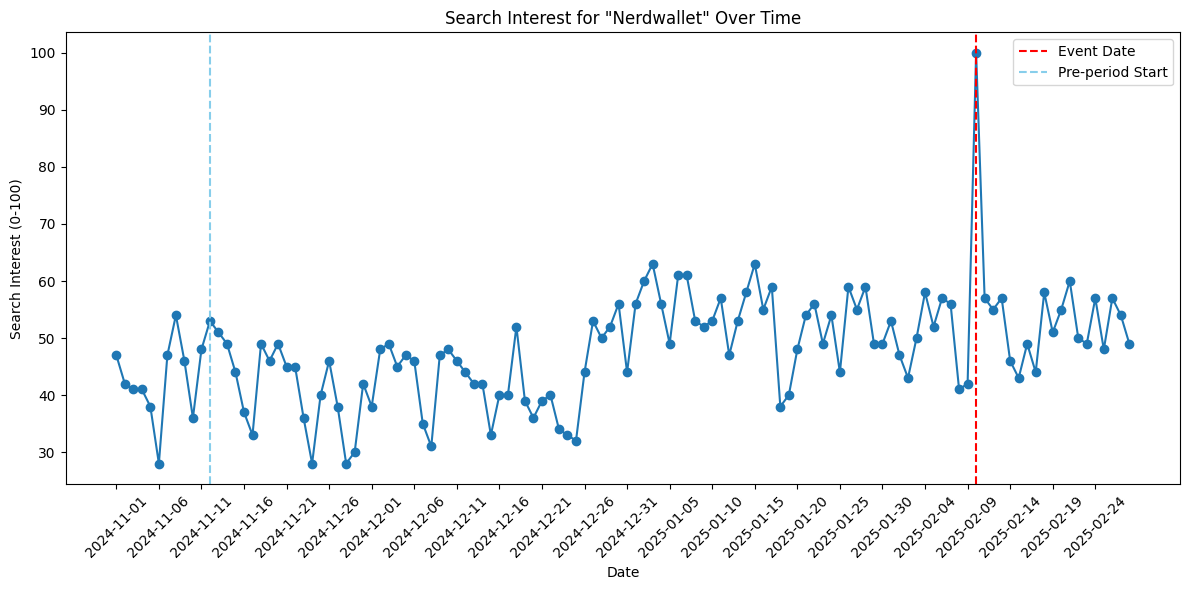

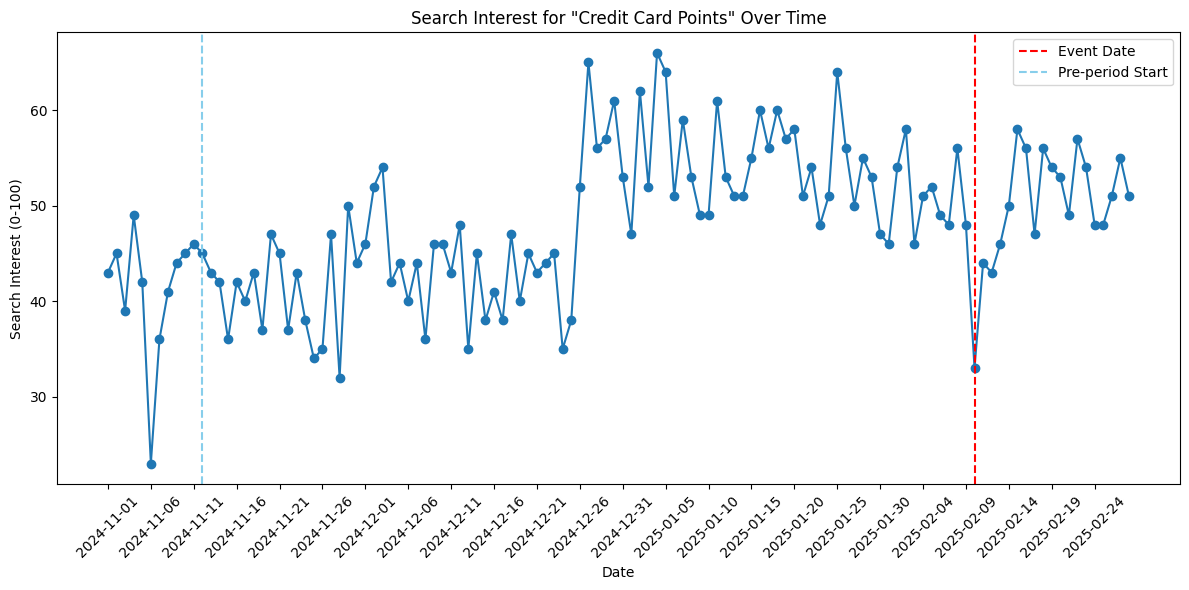

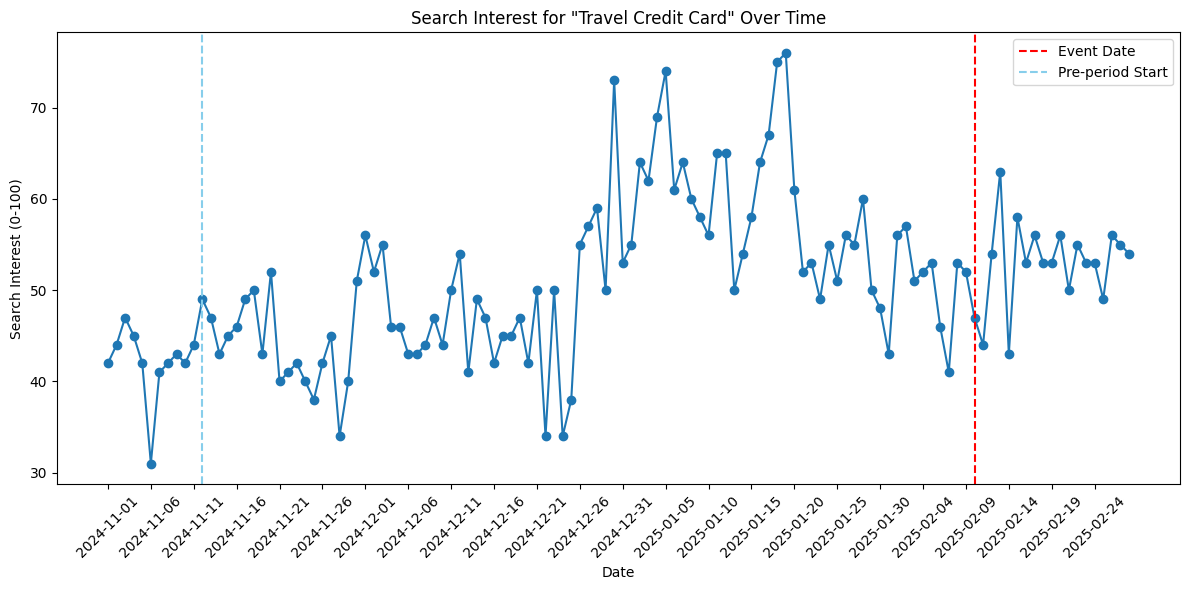

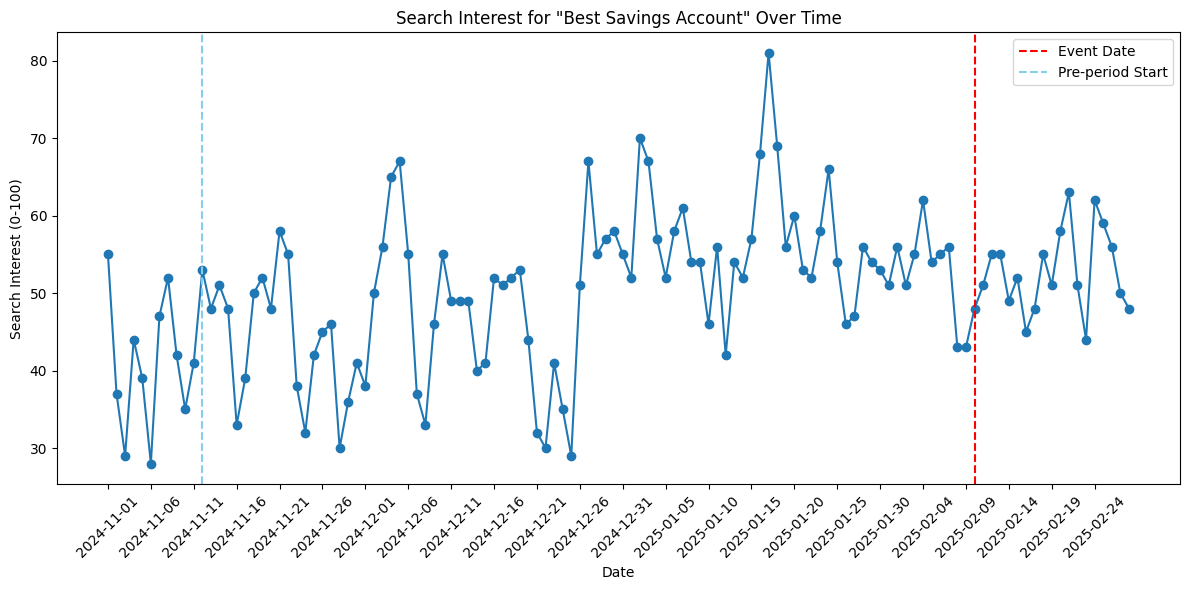

In [8]:
### nerdwallet timeseries plot
keyword_list = ['nerdwallet', 'credit_card_points', 'travel_credit_card', 'best_savings_account']
import matplotlib.pyplot as plt

for keyword in keyword_list:
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df[keyword], marker='o', linestyle='-')
    plt.title(f'Search Interest for "{keyword.replace("_", " ").title()}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Search Interest (0-100)')
    xticks = df['date'][::5]
    plt.xticks(ticks=xticks, labels=xticks, rotation=45)
    # Plot vertical lines for event and pre-period start
    plt.axvline(x=event_date.strftime('%Y-%m-%d'), color='red', linestyle='--', label='Event Date')
    plt.axvline(x=start_date.strftime('%Y-%m-%d'), color='skyblue', linestyle='--', label='Pre-period Start')
    plt.legend()
    plt.tight_layout()
    plt.show()


## Interrupted Time Series (ITS) Modeling

In [16]:
# Fit an ITS model with level change only

# TO-DO: Create indicator for dates on or after treatment start 
event_date = pd.to_datetime(event_date)
df['date'] = pd.to_datetime(df['date'])
df['post_treatment_dummy'] = np.where(df['date']>event_date, 1, 0)
df['trend'] = (pd.to_datetime(df['date']) - event_date).dt.days

# TO-DO: Estimate an ITS model testing for a level change only 
formula = 'nerdwallet ~ trend + post_treatment_dummy'  
its_model = smf.ols(formula = formula, data=df).fit()
print(its_model.summary())

                            OLS Regression Results                            
Dep. Variable:             nerdwallet   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     19.30
Date:                Tue, 04 Nov 2025   Prob (F-statistic):           5.69e-08
Time:                        10:45:41   Log-Likelihood:                -423.76
No. Observations:                 120   AIC:                             853.5
Df Residuals:                     117   BIC:                             861.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               55.0821 

In [20]:
control = its_model.params['Intercept'] + df['trend'] * its_model.params['trend']
treatment = its_model.params['Intercept'] + df['trend'] * its_model.params['trend'] + df['post_treatment_dummy'] * its_model.params['post_treatment_dummy']

Text(0, 0.5, 'Search Interest (0-100)')

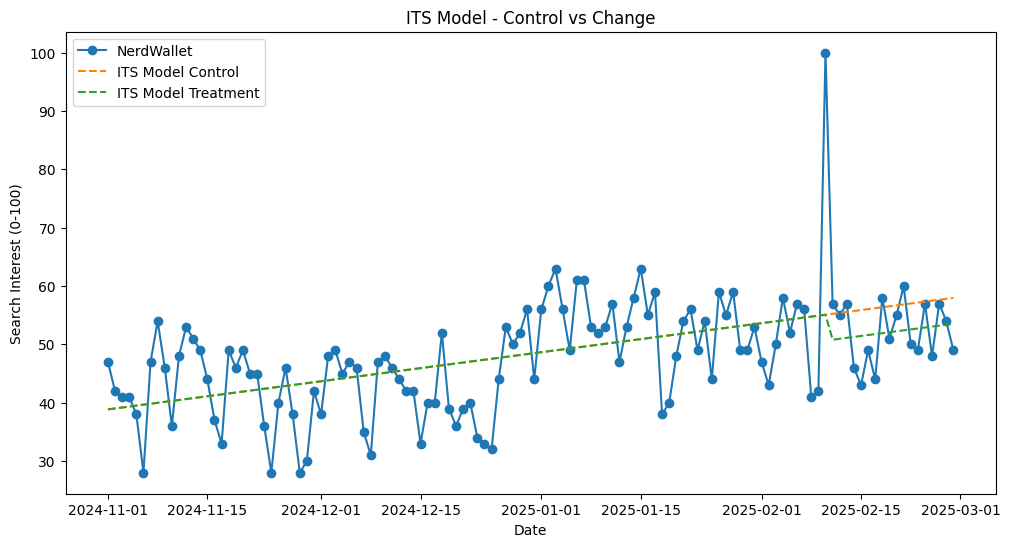

In [21]:
### plot the ITS model - control vs change
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['nerdwallet'], marker='o', linestyle='-', label='NerdWallet')
plt.plot(df['date'], control, linestyle='--', label='ITS Model Control')
plt.plot(df['date'], treatment, linestyle='--', label='ITS Model Treatment')
plt.title('ITS Model - Control vs Change')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Search Interest (0-100)')

## Difference-in-Differences (DiD) Modeling

In [6]:
# TODO: DiD modeling

## Difference-in-Differences Modeling with Controls

In [7]:
# TODO: DiD modeling with controls

## Event Study Modeling

In [8]:
# TODO: Event study modeling

## Estimating a Synthetic Control using Lasso

In [9]:
# TODO: Estimating a synthetic control using Lasso

## Optimizing with Cross-Validation

In [11]:
# TODO: Optimizing with cross-validation

## If necessary, net out pre-period differences using a Difference-in-Differences Model

#### Note: In some cases, the synthetic control may have a poor pre-period fit, or a different pre-treatment average outcome than the treated group. In those cases, you may wish to net out the pre-period differences using a DiD model.  If the pre-period fit is very close, then this step is not necessary; simply compare post-treatment outcomes. 

#### Important: The DiD model underestimates the standard error for synthetic control models and should NOT be used to determine statistical significance. The permutation tests below are for statistical significance and confidence intervals

In [4]:
# TODO: If necessary, DiD modeling with synthetic control 
# or justify why not necessary (e.g. similar pre-treatment average outcome)

## Permutation Testing

#### Note: Obtaining confidence intervals for synthetic controls is a rapidly growing and changing field. At the time of this course, a common approach to determine statistical significance is via permutation testing.  

#### Whether you simply compared post-treatment outcomes or netted out pre-period differences using DiD, be consistent and run the same model structure for the permutation tests

In [2]:
# TODO: Permutation testing

## Final Model Selection and Rationale

TODO: final model selection and rationale

## Sensitivity Tests:  

#### For your chosen final model, adjust at least one hyperparameter (such as pre-period window length) and ensure that the results aren't very sensitive to reasonable model choices

In [3]:
# TODO: Sensitivity Testing

## Key Takeaways for Stakeholders

#### The idea here: Imagine your stakeholders are comfortable with randomized experiments but not with observational causal inference.  What have you done so far in this project to help them feel comfortable that this is actually a reasonable causal estimate?

TODO: key takeaways for stakeholders